# From Primary Source to Data
This Jupyter Notebook is a step-by-step tutorial of the text extraction and dataset building process for the primary source: The Letters of Lady Montagu, originally published in 1763. 


## Text Extraction

This tutorial uses an epub copy of the 1790 edition of Montagu's letters. Instead of dealing with low-quality OCR output and complications related to 18th century orthography and spelling, we chose to use a machine readable copy.

In [3]:
!pip install ebooklib

In [9]:
## Step 1: Text Extraction from ePub

import ebooklib
from ebooklib import epub
from bs4 import BeautifulSoup

def extract_text_from_epub(epub_path, output_txt_path):
    book = epub.read_epub(epub_path)
    text_content = []

    for item in book.get_items():
        if item.get_type() == ebooklib.ITEM_DOCUMENT:
            soup = BeautifulSoup(item.get_content(), 'html.parser')
            text_content.append(soup.get_text())

    # Join extracted text and save to a file
    with open(output_txt_path, 'w', encoding='utf-8') as f:
        f.write('\n'.join(text_content))

    print(f"Text extracted and saved to {output_txt_path}")

# Example usage
epub_file = "../Data/montagu/montagu_2019.epub" 
output_text_file = "../Data/montagu/montagu_2019_unedited.txt"
extract_text_from_epub(epub_file, output_text_file)

Text extracted and saved to ../Data/montagu/montagu_2019_unedited.txt


### Glitches

Historical data is not always very clean, even if it is already processed by contemporary scholars. In this example, I know that I only wanted the letters but there are introductory materials and other scholarly commentary. I prefer to edit these out and often it is easier to do it manually.

After this step, I created a copy of montagu_2019_unedited and renamed it to montagu_2019. Then, I manually removed the materials before the letters and the materials after the letters and saved them to different text files (not shared here). This made the text segmentation process below easier.

In [10]:
## Step 2: Splitting Letters

import os
import re

def split_letters(file_path, output_folder):
    # Ensure output folder exists
    os.makedirs(output_folder, exist_ok=True)

    # Read the entire text file
    with open(file_path, "r", encoding="utf-8") as f:
        text = f.read()

    # Use regex to find all letters (assuming they start with "LETTER. X")
    # Improved regex to handle "LETTER VIII", "LET. VIII", and other variations
    letters = re.split(r"(?=\nLET(?:TER)?(?:\.|\s)\s*[IVXLCDM\d]+)", text)

    # Remove any empty splits
    letters = [letter.strip() for letter in letters if letter.strip()]

    # Save each letter as a separate file
    for i, letter in enumerate(letters, start=1):
        file_name = f"letter_{i}.txt"
        with open(os.path.join(output_folder, file_name), "w", encoding="utf-8") as letter_file:
            letter_file.write(letter)

    print(f"Split {len(letters)} letters into individual files in '{output_folder}'.")

# Example usage
input_file = "../Data/montagu/montagu_2019.txt"  # Path to uploaded file
output_directory = "../Data/montagu/montagu_letters"  # Folder for individual letter files
split_letters(input_file, output_directory)

Split 58 letters into individual files in '../Data/montagu/montagu_letters'.


### Why does this work?

In the code below we relied on a few assumptions about the structure of the extracted letters.

Firstly, We know that the all the extracted letters begin with the letter title. So, we could savely assume this: title = lines[0]

Secondly, we know that the addressee starts with a version of "to" (TO; To; to). With this in mind, we created a regex that searches for this.

Thirdly, we know that the location and date information are in this format: "location, date" (ie: Nuremberg, Aug. 22. O. S. 1716.). We also know that location,date is often the first line with text after the addressee line. We used this information to simplify our search in finding and splitting the location,date. 

At the same time we know that some letters have an editor's note between the addressee and the location,date column in this format: [Footnote: ....] Thus, we introduced a skipping condition to skip the line that contains 'Footnote:'

Lastly, we designated everything after location,date col to be the body of the letter.

Based on these assumptions, we ended up with 51 letters correctly extracted and only 7 needing manual editing. 

In [11]:
# Step 3: CSV
"""
Our goal is to create a CSV with the following columns:
filename, title, addressee, location, date, body

For example
letter_5.txt, LET. V., THE COUNTESS OF B——., Nuremberg, Aug. 22. O. S. 1716., textoftheletter 
"""
import csv

# Define the folder where the letters are stored
letters_folder = "../Data/montagu/montagu_letters" 
output_file = "../Data/montagu/montagu_letters_unedited.csv"

# Helper function to extract the numeric index from the filename
def get_letter_number(filename):
    # Matches filenames like "letter_1.txt" -> returns integer 1
    match = re.match(r"letter_(\d+)\.txt", filename)
    if match:
        return int(match.group(1))
    return float("inf")  # Fallback if it doesn't match the pattern

# List all text files in the folder, then sort numerically
letter_files = [f for f in os.listdir(letters_folder) if f.startswith("letter_") and f.endswith(".txt")]
letter_files.sort(key=get_letter_number)

# Prepare the CSV headers
headers = ["filename", "title", "addressee", "location", "date", "body"]

# Initialize storage for letters
letters_data = []

# Loop through each letter file
for letter_file in letter_files:
    file_path = os.path.join(letters_folder, letter_file)
    print(f"Processing: {file_path}")

    # Read the content of the letter
    with open(file_path, "r", encoding="utf-8") as file:
        lines = [line.strip() for line in file.readlines() if line.strip()]

    if not lines:
        continue  # Skip empty files

    # Extract filename
    filename = letter_file

    # Extract title (first line)
    title = lines[0]

    # Extract addressee (line starting with "To ", "to ", or "TO ")
    addressee = "Unknown"
    addressee_index = None
    for idx, line in enumerate(lines):
        if re.match(r"^(To|TO|to)\s+(.*)", line):
            addressee = line.strip()
            addressee_index = idx
            break

    # Extract location and date (first line after addressee, ignoring footnotes)
    location, date = "Unknown", "Unknown"
    location_date_line = None

    if addressee_index is not None:
        for line in lines[addressee_index + 1:]:  # start after the addressee line
            if "Footnote:" in line:
                continue  # skip footnotes
            location_date_line = line
            break

    if location_date_line:
        # Split by the first comma
        parts = location_date_line.split(",", 1)
        if len(parts) == 2:
            location = parts[0].strip()
            date = parts[1].strip()

    # Extract body (everything after location/date line)
    if location_date_line and location_date_line in lines:
        body_start_idx = lines.index(location_date_line) + 1
    else:
        body_start_idx = addressee_index + 1 if addressee_index is not None else 1

    body = "\n".join(lines[body_start_idx:]).strip()

    # Store data
    letters_data.append([filename, title, addressee, location, date, body])

# Write data to CSV file
with open(output_file, "w", encoding="utf-8", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(headers)  # Write header row
    writer.writerows(letters_data)  # Write letter rows

print(f"CSV file '{output_file}' has been created successfully.")


Processing: ../Data/montagu/montagu_letters/letter_1.txt
Processing: ../Data/montagu/montagu_letters/letter_2.txt
Processing: ../Data/montagu/montagu_letters/letter_3.txt
Processing: ../Data/montagu/montagu_letters/letter_4.txt
Processing: ../Data/montagu/montagu_letters/letter_5.txt
Processing: ../Data/montagu/montagu_letters/letter_6.txt
Processing: ../Data/montagu/montagu_letters/letter_7.txt
Processing: ../Data/montagu/montagu_letters/letter_8.txt
Processing: ../Data/montagu/montagu_letters/letter_9.txt
Processing: ../Data/montagu/montagu_letters/letter_10.txt
Processing: ../Data/montagu/montagu_letters/letter_11.txt
Processing: ../Data/montagu/montagu_letters/letter_12.txt
Processing: ../Data/montagu/montagu_letters/letter_13.txt
Processing: ../Data/montagu/montagu_letters/letter_14.txt
Processing: ../Data/montagu/montagu_letters/letter_15.txt
Processing: ../Data/montagu/montagu_letters/letter_16.txt
Processing: ../Data/montagu/montagu_letters/letter_17.txt
Processing: ../Data/mon

In [16]:
import pandas as pd

# Load the CSV file into a DataFrame
montagu_unedited = pd.read_csv('../Data/montagu/montagu_letters_unedited.csv')
montagu_unedited.head()

,filename,title,addressee,location,date,body
0,letter_1.txt,LETTER I.,TO THE COUNTESS OF ——.,Rotterdam,Aug. 3. O. S. 1716.,"I FLATTER, myself, dear sister, that I shall g..."
1,letter_2.txt,LET. II,TO MRS. S——.,Hague,Aug. 5. O. S. 1716.,"I MAKE haste to tell you, dear Madam, that, af..."
2,letter_3.txt,LET. III,TO MRS. S. C.,Nimeguen,Aug.13. O. S. 1716.,"I AM extremely sorry, my dear S. that your fea..."
3,letter_4.txt,LET. IV.,TO THE LADY ——.,Cologn (sic),"Aug, 16. O. S. 1716.",IF my lady —— could have any notion of the fat...
4,letter_5.txt,LET. V.,TO THE COUNTESS OF B——.,Nuremberg,Aug. 22. O. S. 1716.,"AFTER five days travelling post, I could not s..."


In [27]:
# Let's make sure that we got all the 58 letters
montagu_unedited.shape

(58, 6)

In [28]:
# Some descriptive statistics, especially relevant are unique counts of addressee, location, and date
montagu_unedited.describe()

,filename,title,addressee,location,date,body
count,58,58,58,58,58,58
unique,58,58,25,30,49,58
top,letter_1.txt,LETTER I.,TO THE COUNTESS OF ——.,Vienna,April 1. O. S. 1717.,"I FLATTER, myself, dear sister, that I shall g..."
freq,1,1,14,11,5,1


In [26]:
# What are the data types of the columns?
print(montagu_unedited.dtypes)

filename     object
title        object
addressee    object
location     object
date         object
body         object
dtype: object


In [32]:
# Check for missing values in the DataFrame
print(montagu_unedited.isnull().sum())

filename     0
title        0
addressee    0
location     0
date         0
body         0
dtype: int64


In [31]:
# Another way to check for missing values
montagu_unedited.isna().sum()

filename     0
title        0
addressee    0
location     0
date         0
body         0
dtype: int64

In [ ]:
# Compare isna() vs isna().sum()
# montagu_unedited.isna() returns a DataFrame of boolean values indicating missing data
# montagu_unedited.isna().sum() returns a Series with the count of missing values per column

montagu_unedited.isna()

# This has its own uses too but clearly not what we want here

,filename,title,addressee,location,date,body
0,False,False,False,False,False,False
1,False,False,False,False,False,False
2,False,False,False,False,False,False
3,False,False,False,False,False,False
4,False,False,False,False,False,False
5,False,False,False,False,False,False
6,False,False,False,False,False,False
7,False,False,False,False,False,False
8,False,False,False,False,False,False
9,False,False,False,False,False,False


In [33]:
# We could have also done this with the `info()` method
montagu_unedited.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filename   58 non-null     object
 1   title      58 non-null     object
 2   addressee  58 non-null     object
 3   location   58 non-null     object
 4   date       58 non-null     object
 5   body       58 non-null     object
dtypes: object(6)
memory usage: 2.8+ KB


In [ ]:
# This seems fine?? Are we ready to move on?

# Let's see if we have any unkowns
print('addressee')
print(montagu_unedited[montagu_unedited['addressee'] == 'Unknown'])

print('location')
print(montagu_unedited[montagu_unedited['location'] == 'Unknown'])

print('date')
print(montagu_unedited[montagu_unedited['date'] == 'Unknown'])

addressee
Empty DataFrame
Columns: [filename, title, addressee, location, date, body]
Index: []
location
         filename        title               addressee location     date  \
52  letter_53.txt   LET. LIII.             TO LADY ——.  Unknown  Unknown   
54  letter_55.txt     LET. LV.              TO MR P——.  Unknown  Unknown   
55  letter_56.txt    LET. LVI.  To THE COUNTESS OF ——.  Unknown  Unknown   
57  letter_58.txt  LET. LVIII.        TO THE COUNT ——.  Unknown  Unknown   

                                                 body  
52  I FIND, after all, by your letter of yesterday...  
54  WHEN I wrote to you last, Belgrade was in the ...  
55  I SET out from Bologne (sic) the moment I had ...  
57  I AM charmed, Sir, with your obliging letter; ...  
date
         filename        title               addressee location     date  \
52  letter_53.txt   LET. LIII.             TO LADY ——.  Unknown  Unknown   
54  letter_55.txt     LET. LV.              TO MR P——.  Unknown  Unknown   
5

### Unknown

We employed this trick in our code, where we first created everything with the string 'Unknown' and then filled it in if the information was there. Here is the snippet:

    addressee = "Unknown"
    addressee_index = None
    for idx, line in enumerate(lines):
        if re.match(r"^(To|TO|to)\s+(.*)", line):
            addressee = line.strip()
            addressee_index = idx
            break


In [35]:
# Let's get all the unknowns and see how many we have and in which rows
unknowns = montagu_unedited[(montagu_unedited['addressee'] == 'Unknown') |
                            (montagu_unedited['location'] == 'Unknown') |
                            (montagu_unedited['date'] == 'Unknown')]
print(unknowns)

         filename        title               addressee location     date  \
52  letter_53.txt   LET. LIII.             TO LADY ——.  Unknown  Unknown   
54  letter_55.txt     LET. LV.              TO MR P——.  Unknown  Unknown   
55  letter_56.txt    LET. LVI.  To THE COUNTESS OF ——.  Unknown  Unknown   
57  letter_58.txt  LET. LVIII.        TO THE COUNT ——.  Unknown  Unknown   

                                                 body  
52  I FIND, after all, by your letter of yesterday...  
54  WHEN I wrote to you last, Belgrade was in the ...  
55  I SET out from Bologne (sic) the moment I had ...  
57  I AM charmed, Sir, with your obliging letter; ...  


### Editing

At this point, I decided to edit these unknowns manually. While we want to do a lot of things with code, we also shouldn't forget that manual data cleaning is always an option. Besides you will learn a lot about your dataset by doing that.

I edited these issues and continued with data augmentation on Google Sheets.

Oh and before I forget, I also edited the **dates**. the standard format for dates in computational research is: YYYY-MM-DD

## Data Augmentation

There are three directions that we can go from here

1. **Location** -> Remember the example from '2-4_pandas.ipynb' and how it made use of the locations that the letters were sent to and from? We can do that here too!
    
    For this particular task, I prefer using Google Sheets, especially since we have only a handful letters. My goal here is to ensure that I have a clean csv where the location is uniformly edited and that I can use this location information to augment my dataset.

    This augmentation process includes adding Wikidata IDs and coordinates.

    The result of this process can be found in "Data/montagu/montagu_letters_for_mapping.csv"

2. **Letter bodies** -> We can start analyzing the actual texts of the letters
    This task includes normalizing the texts, running algorithms like POS-tagging and Named Entity Recognition and even getting embeddings for our letter.

3. **People** -> In this edited volume that we extracted the letters from, the editors were kept everything the same as the original 1790 edition. However, in some other editions of Montagu's letters, different scholars have chosen to identify who the recipients were. We can look this information up to augment our dataset

### Letter bodies

Let's start looking at the letter bodies and what they contain, similar to how we analyzed Borges' poem in 2-6_text_analysis_introduction.ipynb



In [51]:
# Let's get the most updated version of our data
# We will use the version that has been manually corrected

montagu = pd.read_csv('../Data/montagu/montagu_letters_v1.csv')

In [52]:
montagu.head()

,filename,title,addressee,location_original,location_edited,location_wikidata,latitude,longitude,date_original,date_edited,body
0,letter_1.txt,LETTER I.,TO THE COUNTESS OF ——.,Rotterdam,Rotterdam,Q34370,51.92,4.480000,Aug. 3. O. S. 1716.,1716-08-03,"I FLATTER, myself, dear sister, that I shall g..."
1,letter_2.txt,LET. II,TO MRS. S——.,Hague,Hague,Q36600,52.08,4.310000,Aug. 5. O. S. 1716.,1716-08-05,"I MAKE haste to tell you, dear Madam, that, af..."
2,letter_3.txt,LET. III,TO MRS. S. C.,Nimeguen,Nimeguen,Q47887,51.8475,5.862500,Aug.13. O. S. 1716.,1716-08-13,"I AM extremely sorry, my dear S. that your fea..."
3,letter_4.txt,LET. IV.,TO THE LADY ——.,Cologn (sic),Cologne,Q365,50.94222222,6.957778,"Aug, 16. O. S. 1716.",1716-08-16,IF my lady —— could have any notion of the fat...
4,letter_5.txt,LET. V.,TO THE COUNTESS OF B——.,Nuremberg,Nuremberg,Q2090,49.45388889,11.077500,Aug. 22. O. S. 1716.,1716-08-22,"AFTER five days travelling post, I could not s..."


In [53]:
# Looks good! Let's get one letter and start working with it

letter_35 = montagu['body'].iloc[34]  # Remember that iloc is zero-indexed
print(letter_35)


I HAVE had the advantage of very fine weather, all my journey; and as the summer is now in its beauty, I enjoyed
the pleasure of fine prospects; and the meadows being full of all sorts of garden flowers, and sweet herbs, my
berlin perfumed the air as it pressed them. The grand signior furnished us with thirty covered waggons for our
baggage, and five coaches of the country for my women. We found the road full of the great spahis and their
equipages coming out of Asia to the war. They always travel with tents; but I chose to ly in houses all the way.
I will not trouble you with the names of the villages we passed, in which there was nothing remarkable, but at
Ciorlei, where there was a conac, or little seraglio, built for the use of the grand signior, when he goes
this road. I had the curiosity to view all the apartments destined for the ladies of his court. They were in the
midst of a thick grove of trees, made fresh by fountains; but I was most surprised to see the walls almost
covere

In [54]:
# Let's get some basic statistics about the letter

print(f"Length of letter 35: {len(letter_35)} characters")
print(f"Number of words in letter 35: {len(letter_35.split())} words")

Length of letter 35: 9685 characters
Number of words in letter 35: 1799 words


In [44]:
# Before we continue, let's split the letter into sentences

import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import sent_tokenize

# Tokenize the letter into sentences
letter_35_sentences = sent_tokenize(letter_35)

print(f"Number of sentences in letter 35: {len(letter_35_sentences)}")

counter = 1
for sentence in letter_35_sentences:
    print(counter) 
    print(sentence)
    counter += 1

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/mervetekgurler/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/mervetekgurler/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Number of sentences in letter 35: 69
1
I HAVE had the advantage of very fine weather, all my journey; and as the summer is now in its beauty, I enjoyed
the pleasure of fine prospects; and the meadows being full of all sorts of garden flowers, and sweet herbs, my
berlin perfumed the air as it pressed them.
2
The grand signior furnished us with thirty covered waggons for our
baggage, and five coaches of the country for my women.
3
We found the road full of the great spahis and their
equipages coming out of Asia to the war.
4
They always travel with tents; but I chose to ly in houses all the way.
5
I will not trouble you with the names of the villages we passed, in which there was nothing remarkable, but at
Ciorlei, where there was a conac, or little seraglio, built for the use of the grand signior, when he goes
this road.
6
I had the curiosity to view all the apartments destined for the ladies of his court.
7
They were in the
midst of a thick grove of trees, made fresh by fountains; but 

In [55]:
# When we split it sentence by sentence, we can see that the sentences have some line break issues
# Sometimes analyzing the text can reveal formatting issues that need to be addressed, 
# especially when dealing with historical texts or texts extracted from formats like ePub.

# Let's fix the line breaks in the actual letter

letter_35_test = letter_35.replace('\n', ' ')

letter_35_sentences_test = sent_tokenize(letter_35_test)

print(f"Number of sentences in letter 35: {len(letter_35_sentences_test)}")

counter = 1
for sentence in letter_35_sentences_test:
    print(counter) 
    print(sentence)
    counter += 1


Number of sentences in letter 35: 69
1
I HAVE had the advantage of very fine weather, all my journey; and as the summer is now in its beauty, I enjoyed the pleasure of fine prospects; and the meadows being full of all sorts of garden flowers, and sweet herbs, my berlin perfumed the air as it pressed them.
2
The grand signior furnished us with thirty covered waggons for our baggage, and five coaches of the country for my women.
3
We found the road full of the great spahis and their equipages coming out of Asia to the war.
4
They always travel with tents; but I chose to ly in houses all the way.
5
I will not trouble you with the names of the villages we passed, in which there was nothing remarkable, but at Ciorlei, where there was a conac, or little seraglio, built for the use of the grand signior, when he goes this road.
6
I had the curiosity to view all the apartments destined for the ladies of his court.
7
They were in the midst of a thick grove of trees, made fresh by fountains; but 

In [ ]:
# Now we can see that the sentences are much cleaner and easier to read
# Let's save the cleaned letter back to the DataFrame and use the same approach for all letters

# We will talk more about the lambda function next week

montagu['body_cleaned'] = montagu['body'].apply(lambda x: x.replace('\n', ' '))

# Now let's save the updated DataFrame to a new CSV file
montagu.to_csv('../Data/montagu/montagu_letters_v2.csv', index=False) # note the name change here! versioning is important

In [ ]:
# Let's go back to working with Letter 35
# We will override the previous letter_35 variable to use the cleaned version

letter_35 = montagu['body_cleaned'].iloc[34]  # Remember that iloc is zero-indexed

In [60]:
print(f"Length of letter 35: {len(letter_35)} characters")
print(f"Number of words in letter 35: {len(letter_35.split())} words")

Length of letter 35: 9685 characters
Number of words in letter 35: 1799 words


In [ ]:
# How many unique words are in the letter?

print(f"Unique words in letter 35: {len(set(letter_35.split()))}")

Unique words in letter 35: 789


In [62]:
# Aren't we forgetting something?

# Ah yes, lowercase! Let's convert the letter to lowercase and then count unique words

letter_35_lower = letter_35.lower()
unique_words = set(letter_35_lower.split())
print(f"Unique words in letter 35 (lowercase): {len(unique_words)}")

Unique words in letter 35 (lowercase): 760


In [64]:
# Let's tokenize our sentences again and this time we will use the lowercase version of the letter
sentences = sent_tokenize(letter_35_lower)

counter = 1
for sentence in sentences[:5]: # only print the first 5
    print(counter) 
    print(sentence)
    counter += 1

1
i have had the advantage of very fine weather, all my journey; and as the summer is now in its beauty, i enjoyed the pleasure of fine prospects; and the meadows being full of all sorts of garden flowers, and sweet herbs, my berlin perfumed the air as it pressed them.
2
the grand signior furnished us with thirty covered waggons for our baggage, and five coaches of the country for my women.
3
we found the road full of the great spahis and their equipages coming out of asia to the war.
4
they always travel with tents; but i chose to ly in houses all the way.
5
i will not trouble you with the names of the villages we passed, in which there was nothing remarkable, but at ciorlei, where there was a conac, or little seraglio, built for the use of the grand signior, when he goes this road.


In [66]:
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger_eng') 
from nltk.tokenize import word_tokenize

# Sample sentence for POS tagging
sample_sentence = sentences[0]  # First sentence for demonstration

# Apply POS tagging
pos_tags = pos_tag(word_tokenize(sample_sentence))

print(f"POS Tags for the sample sentence: {pos_tags}")


[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/mervetekgurler/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


POS Tags for the sample sentence: [('i', 'NN'), ('have', 'VBP'), ('had', 'VBN'), ('the', 'DT'), ('advantage', 'NN'), ('of', 'IN'), ('very', 'RB'), ('fine', 'JJ'), ('weather', 'NN'), (',', ','), ('all', 'DT'), ('my', 'PRP$'), ('journey', 'NN'), (';', ':'), ('and', 'CC'), ('as', 'IN'), ('the', 'DT'), ('summer', 'NN'), ('is', 'VBZ'), ('now', 'RB'), ('in', 'IN'), ('its', 'PRP$'), ('beauty', 'NN'), (',', ','), ('i', 'JJ'), ('enjoyed', 'VBD'), ('the', 'DT'), ('pleasure', 'NN'), ('of', 'IN'), ('fine', 'JJ'), ('prospects', 'NNS'), (';', ':'), ('and', 'CC'), ('the', 'DT'), ('meadows', 'NNS'), ('being', 'VBG'), ('full', 'JJ'), ('of', 'IN'), ('all', 'DT'), ('sorts', 'NNS'), ('of', 'IN'), ('garden', 'NN'), ('flowers', 'NNS'), (',', ','), ('and', 'CC'), ('sweet', 'JJ'), ('herbs', 'NN'), (',', ','), ('my', 'PRP$'), ('berlin', 'NN'), ('perfumed', 'VBD'), ('the', 'DT'), ('air', 'NN'), ('as', 'IN'), ('it', 'PRP'), ('pressed', 'VBD'), ('them', 'PRP'), ('.', '.')]


### What are POS tags anyways?

POS tagging (Part-of-Speech tagging) is the process of assigning a specific part-of-speech category (e.g., noun, verb, adjective, etc.) to each word in a sentence. This helps in understanding the grammatical structure of a sentence and is a key step in many natural language processing (NLP) tasks such as information extraction, machine translation, and text analysis.

POS tags typically include categories like:

- Nouns (e.g., "dog", "city")

- Verbs (e.g., "run", "is")

- Adjectives (e.g., "quick", "beautiful")

- Adverbs (e.g., "quickly", "very")

- Pronouns (e.g., "he", "they")

- Prepositions (e.g., "in", "on")

- Conjunctions (e.g., "and", "but")





### POS Tags in our example

- **NN (Noun, Singular)**: Represents singular nouns.
    - *advantage, weather, journey, summer, beauty, pleasure, prospects, meadows, flowers, herbs, air*

- **VBP (Verb, Non-3rd Person Singular Present)**: A verb in the present tense used with subjects other than third-person singular (he/she/it).
    - *have*

- **VBN (Verb, Past Participle)**: A verb in past participle form, often used with auxiliary verbs.
    - *had*

- **DT (Determiner)**: A word that introduces a noun.
    - *the, all*

- **IN (Preposition/Subordinating Conjunction)**: Used to show relationships between elements in the sentence.
    - *of, in, as*

- **RB (Adverb)**: Modifies or describes a verb, adjective, or another adverb.
    - *very, now*

- **JJ (Adjective)**: Describes or modifies a noun.
    - *fine, sweet*

- **PRP$ (Possessive Pronoun)**: A pronoun that shows ownership or possession.
    - *my, its*

- **VBD (Verb, Past Tense)**: A verb in the simple past tense.
    - *enjoyed, perfumed, pressed*

- **CC (Coordinating Conjunction)**: Used to connect words, phrases, or clauses of equal importance.
    - *and*

- **PRP (Personal Pronoun)**: Refers to a person or thing.
    - *I, it, them*

- **NNS (Noun, Plural)**: Represents plural nouns.
    - *prospects, meadows, sorts, flowers, herbs*

- **. (Punctuation)**: Marks the end of a sentence or clause.
    - *.*


### What can we do with POS Tagging?

We can analyze the structure of the sentences, identify parts of speech, and even extract specific types of words.

For example, we can extract all adjectives from this letter.

In [67]:
# What can we do with POS Tagging?
# We can analyze the structure of the sentences, identify parts of speech, and even extract specific types of words.
# For example, we can extract all adjectives from this letter.

# First we need to create a function that extracts adjectives from a sentence
def extract_adjectives(sentence):
    words = word_tokenize(sentence)
    pos_tags = pos_tag(words)
    adjectives = [word for word, tag in pos_tags if tag.startswith('JJ')]  # 'JJ' is the tag for adjectives
    return adjectives



In [68]:
# Let's check to see that our function works
sample_sentence = sentences[0]  # First sentence for demonstration
adjectives = extract_adjectives(sample_sentence)
print(f"Adjectives in the sample sentence: {adjectives}")

Adjectives in the sample sentence: ['fine', 'i', 'fine', 'full', 'sweet']


In [70]:
# Our function works! But it is not without issues.
# Why is i and full in the list of adjectives?

print(sample_sentence)
print(f"POS Tags for the sample sentence: {pos_tags}")

i have had the advantage of very fine weather, all my journey; and as the summer is now in its beauty, i enjoyed the pleasure of fine prospects; and the meadows being full of all sorts of garden flowers, and sweet herbs, my berlin perfumed the air as it pressed them.
POS Tags for the sample sentence: [('i', 'NN'), ('have', 'VBP'), ('had', 'VBN'), ('the', 'DT'), ('advantage', 'NN'), ('of', 'IN'), ('very', 'RB'), ('fine', 'JJ'), ('weather', 'NN'), (',', ','), ('all', 'DT'), ('my', 'PRP$'), ('journey', 'NN'), (';', ':'), ('and', 'CC'), ('as', 'IN'), ('the', 'DT'), ('summer', 'NN'), ('is', 'VBZ'), ('now', 'RB'), ('in', 'IN'), ('its', 'PRP$'), ('beauty', 'NN'), (',', ','), ('i', 'JJ'), ('enjoyed', 'VBD'), ('the', 'DT'), ('pleasure', 'NN'), ('of', 'IN'), ('fine', 'JJ'), ('prospects', 'NNS'), (';', ':'), ('and', 'CC'), ('the', 'DT'), ('meadows', 'NNS'), ('being', 'VBG'), ('full', 'JJ'), ('of', 'IN'), ('all', 'DT'), ('sorts', 'NNS'), ('of', 'IN'), ('garden', 'NN'), ('flowers', 'NNS'), (',', ',

POS Tags for the sample sentence: [('i', 'NN'), ('have', 'VBP'), ('had', 'VBN'), ('the', 'DT'), ('advantage', 'NN'), ('of', 'IN'), ('very', 'RB'), **('fine', 'JJ')**, ('weather', 'NN'), (',', ','), ('all', 'DT'), ('my', 'PRP$'), ('journey', 'NN'), (';', ':'), ('and', 'CC'), ('as', 'IN'), ('the', 'DT'), ('summer', 'NN'), ('is', 'VBZ'), ('now', 'RB'), ('in', 'IN'), ('its', 'PRP$'), ('beauty', 'NN'), (',', ','), **('i', 'JJ')**, ('enjoyed', 'VBD'), ('the', 'DT'), ('pleasure', 'NN'), ('of', 'IN'), **('fine', 'JJ')**, ('prospects', 'NNS'), (';', ':'), ('and', 'CC'), ('the', 'DT'), ('meadows', 'NNS'), ('being', 'VBG'), **('full', 'JJ')**, ('of', 'IN'), ('all', 'DT'), ('sorts', 'NNS'), ('of', 'IN'), ('garden', 'NN'), ('flowers', 'NNS'), (',', ','), ('and', 'CC'), **('sweet', 'JJ')**, ('herbs', 'NN'), (',', ','), ('my', 'PRP$'), ('berlin', 'NN'), ('perfumed', 'VBD'), ('the', 'DT'), ('air', 'NN'), ('as', 'IN'), ('it', 'PRP'), ('pressed', 'VBD'), ('them', 'PRP'), ('.', '.')]

In [82]:
# We can improve our function by filtering out certain words that are not adjectives

# Here we rely on a simple heuristic: if the word that is tagged as an adjective is followed by a noun, it is likely an adjective.

def extract_adjectives_improved(sentence):
    sentence = sentence.lower()  # Convert to lowercase for consistency
    words = word_tokenize(sentence)
    tagged_words = pos_tag(words)
    adjectives = []
    for i in range(len(tagged_words) - 1):
        current_word, current_tag = tagged_words[i]
        next_word, next_tag = tagged_words[i + 1]
        if current_tag.startswith('JJ') and next_tag.startswith('NN'):
            adjectives.append(current_word)
    return adjectives

In [83]:
print(extract_adjectives_improved(sample_sentence))

['fine', 'fine', 'sweet']


Much better! Let's scale this up!

In [84]:
# Let's get adjectives from all sentences in the letter
all_adjectives = []
for sentence in sentences:
    adjectives = extract_adjectives_improved(sentence)
    all_adjectives.extend(adjectives)

print(all_adjectives)

['fine', 'fine', 'sweet', 'grand', 'great', 'little', 'grand', 'thick', 'little', 'turkish', 'ancient', 'next', 'noble', 'good', 'thirty-two', 'famous', 'greek', 'greek', 'ill-built', 'same', 'roman-catholic', 'finest', 'monstrous', 'more', 'good', 'great', 'kujuk', 'little', 'pleasant', 'large', 'marble', 'good', 'agreeable', 'own', 'tall', 'nest', 'fifty', 'best', 'next', 'good', 'young', 'high', 'distant', 'beautiful', 'french', 'own', 'i', 'whole', 'vast', 'several', 'inconsiderable', 'great', 'other', 'ancient', 'fine', 'different', 'simple', 'other', 'particular', 'great', 'i', 'solemn', 'other', 'other', 'forth', 'public', 'celestial', 'inferior', 'good', 'eternal', 'ten', 'useless', 'perpetual', 'greek', 'professed', 'valuable', 'macedonian', 'greek', 'grand', 'great', 'best', 'greek', 'same', 'great', 'considerable', 'god', 'old', 'close', 'famous']


### Why extend and not append?

Last week we learnt to use `append()` to add an element to a list. Now we are using `extend()` instead. Why?

`append()` simply adds 'adjectives' in each iteration of the for loop to the list 'all_adjectives'. In this case 'adjectives' is also a list. This means that if we used `append()` we would be creating a list of lists. What we actually want is to create a list of strings, so we need to `extend()` our list 'all_adjectives' with the strings in the list 'adjectives' every time that list is created. 

In [85]:
# Let's get the unique adjectives from the letter and count them
print(f"Unique adjectives in letter 35: {len(set(all_adjectives))}")

Unique adjectives in letter 35: 60


In [86]:
# Let's see all the unique adjectives in the letter and their counts
from collections import Counter
adjective_counts = Counter(all_adjectives)

# Print the most common 10 adjectives
for adj in adjective_counts.most_common(10):
    print(f"{adj[0]}: {adj[1]}")


great: 6
good: 5
greek: 5
other: 4
fine: 3
grand: 3
little: 3
ancient: 2
next: 2
famous: 2


In [87]:
# Perfect! Now let's do this for all letters in the dataset and save the results in a new column in the DataFrame
montagu['adjectives'] = montagu['body_cleaned'].apply(lambda x: extract_adjectives_improved(x))

In [88]:
montagu['adjectives'].head()

0    [dear, ill, sunday, i, dry, little, new, broad...
1    [dreadful, short, sure, whole, large, large, l...
2    [dear, agreeable, nottingham, more, same, juli...
3    [last, great, nimeguen, indifferent, first, th...
4    [other, dear, large, free, little, dirty, nast...
Name: adjectives, dtype: object

In [92]:
# Finally, let's get all the unique adjectives from all letters and their counts

adjectives_all_letters = []
for adjectives in montagu['adjectives']:
    adjectives_all_letters.extend(adjectives)

adjective_counts_all_letters = Counter(adjectives_all_letters)

for adj in adjective_counts_all_letters.most_common(10):
    print(f"{adj[0]}: {adj[1]}")



great: 156
other: 91
same: 85
little: 82
own: 63
fine: 61
good: 59
large: 53
turkish: 51
dear: 50


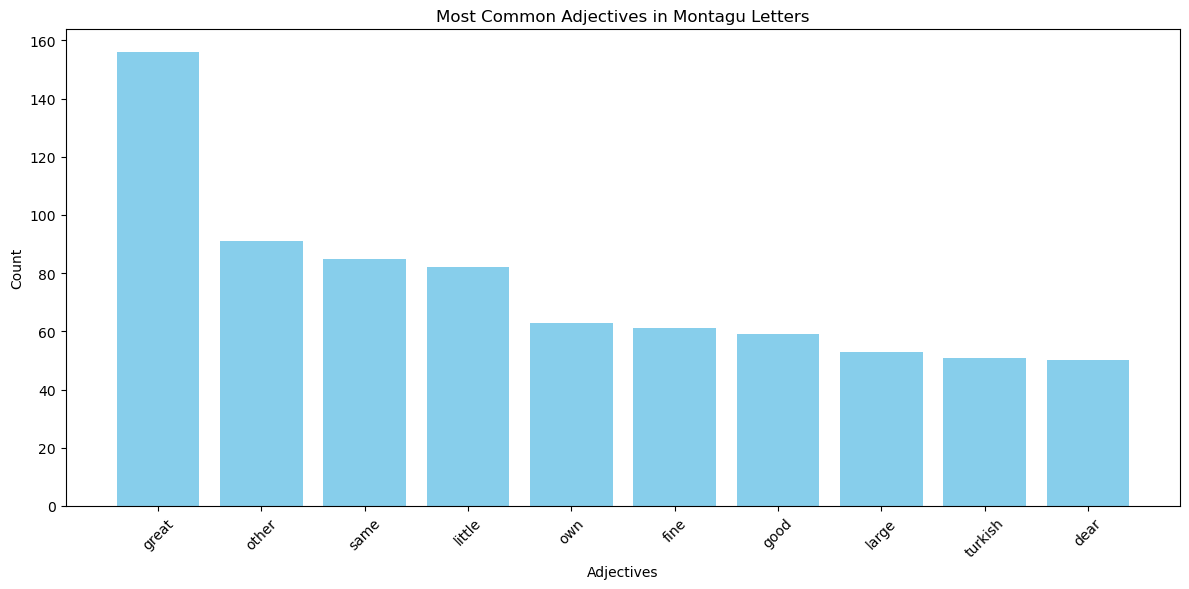

In [93]:
# Let's visualize the most common adjectives in a bar chart
import matplotlib.pyplot as plt
# Get the most common adjectives and their counts
most_common_adjectives = adjective_counts_all_letters.most_common(10)
adjectives, counts = zip(*most_common_adjectives)
plt.figure(figsize=(12, 6))
plt.bar(adjectives, counts, color='skyblue')
plt.xlabel('Adjectives')
plt.ylabel('Count')
plt.title('Most Common Adjectives in Montagu Letters')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()